Here, we demonstrate how to build a simple neural network with `boomdiff`. We will try to solve a non-linear fucntion fitting problem with a user-constructed neural network

#### 0. Problem description

We will first synthesize N 2D X-y pairs by a comparatively complex nonlinear function. Then, we will construct a neural network with 2 hidden layers, then we use feedforward of the neural network simulate the nonlinear function, via minimizing the target function with respect to all parameters in the neural network:

$${\arg \min}_{W} \frac{1}{N}[\sum_{k=1}^N(f_W(X)-y)^2]$$

#### 1. Import necessary packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from boomdiff import AD, optimize, loss_function

from tqdm import tqdm

In [2]:
np.random.seed(87)

#### 2. Prepare synthetic data

In [3]:
def f_true(x):
    return x**3 + 4*x**2 + 2.5 + 10*np.sin(x*2)

X_train = np.linspace(-3,3,100)
y_train = f_true(X_train) + np.random.normal(0,1,size=100)

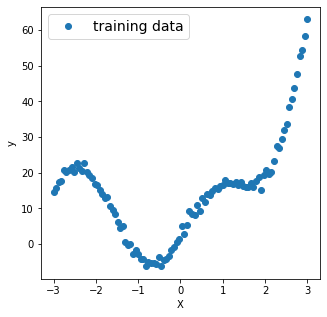

In [4]:
# Visualize
plt.figure(figsize=[5,5])
plt.plot(X_train,y_train,'o',label='training data')
plt.legend(fontsize=14)
plt.xlabel('X')
plt.ylabel('y')
plt.show()

#### 3. Construct a neural network and initialize parameters

Initialize all the parameters for the 2-hidden layer NN

In [5]:
width = 8 # Hidden layer width

# Input Neuron - First Hidden Layer
W1 = AD.from_array(np.random.normal(0,1,size=width), "W1")
b1 = AD.from_array(np.random.normal(0,1,size=width), "b1")

# First Hidden Layer - Second Hidden Layer
W2 = AD.from_array(np.random.normal(0,1,size=(width,width)), "W2")
b2 = AD.from_array(np.random.normal(0,1,size=width), "b2")

# Second Hidden Layer - Output neuron
W3 = AD.from_array(np.random.normal(0,1,size=width), "W3")
b3 = AD.from_array(np.random.normal(0,1,size=1), "b3")

In [6]:
parameter_array = np.concatenate((W1, b1, W2.reshape(-1), b2, W3, b3))

Define a feedforward function $f_W(x)$ with all the parameters

In [7]:
def feedforward(X):
    h1 = X.reshape((-1,1))@W1.reshape(1,-1) + b1 #linear connection
    h1_nl = AD.tanh(h1) #add nonlinearity
    
    h2 = (h1_nl@W2) + b2 #linear connection
    h2_nl = AD.tanh(h2) #add nonlinearity
    
    y_pred = h2_nl@W3 + b3
    
    return y_pred

#### 4. Define the MSE loss function

In [8]:
loss = lambda: AD.mean((feedforward(X_batch) - y_batch)**2)

#### 5. Initialize an optimizer

In [9]:
opt = optimize.Adam(learning_rate=0.01)

#### 6. Update parameters in the neural network, in a batch-epoch manner

In [10]:
n_epochs = 1000
batch_size = 50

for epochs in tqdm(range(n_epochs)):
    index = np.random.permutation(100)
    
    for i in range(int(100/batch_size)):
        index_i = index[i*batch_size:min(100,(i+1)*batch_size)]
        X_batch = X_train[index_i]
        y_batch = y_train[index_i]
        opt.step(loss, parameter_array, record=True)

100%|██████████| 1000/1000 [06:28<00:00,  2.57it/s]


#### 7. Show the results

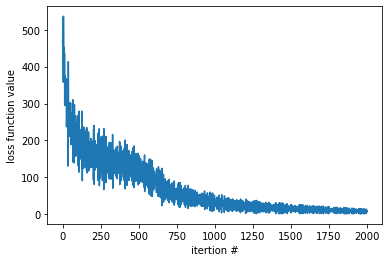

In [11]:
opt.plot_loss_func()

#### 8. Evaluate the results

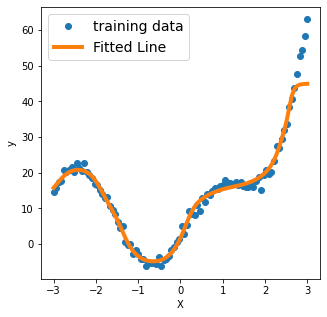

In [12]:
# visualize the fitted curve
plt.figure(figsize=[5,5])
plt.plot(X_train,y_train,'o',label='training data')
plt.plot(X_train,AD.to_array(feedforward(X_train)), lw=4, label='Fitted Line')
plt.legend(fontsize=14)
plt.xlabel('X')
plt.ylabel('y')
plt.show()